In this notebook we analyse the clearance rates for each year, comparing it to the total number of cases and grouped by categories of offenses.

In [2]:
#importing packages

%pip install tabula-py
%pip install tueplots

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
from tueplots import bundles
from tueplots.constants.color import rgb
import math
import scipy.stats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 10.6 MB/s eta 0:00:00


Between 2002 and 2013 the datasets were only available in PDF format, so in a preprocessing step we extracted the data to excel files. Also in these years there are fewer features for each offence category, so we read these files separately.

In [3]:
#reading all cases between 2002 and 2013
cases = []
cases_col_names = ['Key', 'Offence', 'Recorded Cases', 'Recorded Cases Previous Year', 'Change in number', 'Change in %', 'CR% This Year']

for i in range(2,14):
  if(i<10):
    cases_in_this_year = pd.read_excel(f'Cases200{i}.xlsx', skiprows=0)
  else:
    cases_in_this_year = pd.read_excel(f'Cases20{i}.xlsx', skiprows=0)
  for j in range(len(cases_col_names)):
    cases_in_this_year.columns.array[j] = cases_col_names[j]
  to_drop = []
  i = 0
  for ind in cases_in_this_year.index:
    if cases_in_this_year['Key'].isnull()[i] == True:
        to_drop.append(i)
    i += 1
  cases_in_this_year = cases_in_this_year.drop(index=to_drop, axis=0)
  cases_in_this_year = cases_in_this_year.reset_index()
  cases_in_this_year = cases_in_this_year.drop(columns=['index'])

  cases.append(cases_in_this_year)
cases[0]

,Key,Offence,Recorded Cases,Recorded Cases Previous Year,Change in number,Change in %,CR% This Year
0,----,Total offenses,6507394,6363865,143529,2.3,52.6
1,0000,Offenses against life,3541,3577,-36,-1.0,94.5
2,0100,murder (Sect. 211 PC),873,860,13,1.5,96.7
3,0110,robbery attended with murder,64,99,-35,x,95.3
4,0120,sexual murder,27,24,3,x,114.8
...,...,...,...,...,...,...,...
396,8935,economic crime in connection with,14668,13538,1130,8.3,100.3
397,8936,fraud and breach of trust in connection with,16422,36393,-19971,-54.9,99.7
398,8960,offenses against provisions designed to,993,1016,-23,-2.3,91.3
399,8970,computer crime,57488,79283,-21795,-27.5,50.0


In [4]:
#reading all cases, suspects, victims, and developement files between 2014 and 2022
suspects = []
victims = []
developments = []

cases_col_names = ['Key', 'Offence', 'Recorded Cases', 'Percentage of All Cases', 'Attempts', 'Attempts in %', 'Inhabitants < 20k', '20k < Inhabitants < 100k', '100k < Inhabitants < 500k',
             'Inhabitants > 500k', 'Number of Inhabitants Unknown', 'Threatened with Firearm', 'Shot', 'Clearance', 'Clearance in %', 'Number of Suspects Recorded', 'Male Suspects',
             'Female Suspects', 'Number of Non-German Suspects', 'Non-German Suspects in %']
suspects_col_names = ['Key', 'Offence', 'Sex', 'Number of Suspects', 'Age < 6', '6 < Age < 8', '8 < Age < 10', '10 < Age < 12', '12 < Age < 14',
             'Age < 14', '14 < Age < 16', '16 < Age < 18', '14 < Age < 18', '18 < Age < 21', 'Age < 21', '21 < Age < 23', '23 < Age < 25',
             '21 < Age < 25', '25 < Age < 30', '30 < Age < 40', '40 < Age < 50', '50 < Age < 60', '60 < Age', '21 < Age']
victims_col_names = ['Key', 'Offence', 'Case status', 'Total', 'Male', 'Female', 'Total Age < 6', 'Male Age < 6', 'Female Age < 6',
                     'Total 6 < Age < 14', 'Male 6 < Age < 14', 'Female 6 < Age < 14', 'Total Age < 14', 'Male Age < 14', 'Female Age < 14',
                     'Total 14 < Age < 18', 'Male 14 < Age < 18', 'Female 14 < Age < 18', 'Total 18 < Age < 21', 'Male 18 < Age < 21', 'Female 18 < Age < 21',
                     'Total 21 < Age < 60', 'Male 21 < Age < 60', 'Female 21 < Age < 60', 'Total 60 < Age', 'Male 60 < Age', 'Female 60 < Age',
                     'Total 21 < Age', 'Male 21 < Age', 'Female 21 < Age']
developments_col_names = ['Change', 'Key', 'Offence', 'Recorded cases this year', 'Recorded cases previous year', 'Change number', 'Change in %', 'CR% this year', 'CR% previous year']

for i in range(14,23):
  cases_in_this_year = pd.read_excel(f'pks20{i}CasesBasicTable_excel.xlsx', skiprows=7)
  suspects_in_this_year = pd.read_excel(f'pks20{i}Suspects_excel.xlsx', skiprows=8)
  victims_in_this_year = pd.read_excel(f'pks20{i}Victims_excel.xlsx', skiprows=6)
  developments_in_this_year = pd.read_excel(f'pks20{i}CasesDevelopment_excel.xlsx', skiprows=17)

  #cases_in_this_year = cases_in_this_year.drop(cases_in_this_year.columns[0], axis=1)
  #suspects_in_this_year = suspects_in_this_year.drop(suspects_in_this_year.columns[0], axis=1)
  #victims_in_this_year = victims_in_this_year.drop(victims_in_this_year.columns[0], axis=1)

  for j in range(len(cases_col_names)):
    cases_in_this_year.columns.array[j] = cases_col_names[j]
  for j in range(len(suspects_col_names)):
    suspects_in_this_year.columns.array[j] = suspects_col_names[j]
  for j in range(len(victims_col_names)):
    victims_in_this_year.columns.array[j] = victims_col_names[j]
  for j in range(len(developments_col_names)):
    developments_in_this_year.columns.array[j] = developments_col_names[j]

  cases.append(cases_in_this_year)
  suspects.append(suspects_in_this_year)
  victims.append(victims_in_this_year)
  developments.append(developments_in_this_year)

In the next session we consider blue-collar and white-collar crimes separately. The offence keys starting with 0,1,2,3,4 and * contain the most tipical blue-collar crimes, while the offences with keys starting with 5 cover the most frequent white-collar crimes.

In [8]:
# Create a master dataframe with the unique offenses from all dataframes
unique_offenses = pd.concat([development[['Offence']] for development in developments], ignore_index=True)['Offence'].unique()
master_df = pd.DataFrame(unique_offenses, columns=['Offence'])


# Create a dataframe for clearance rates for all years
clearance_rates_df = pd.DataFrame({'Offence': master_df['Offence']})

# Merge clearance rates for each year into the clearance_rates_df
for i, df in enumerate(developments):
    clearance_rates_df = clearance_rates_df.merge(df[['Offence', 'CR% this year']], on='Offence', how='left')

    # Rename the clearance rate column to include the year
    clearance_rates_df = clearance_rates_df.rename(columns={'CR% this year': f'ClearanceRate_{2014 + i}'})

# Now, merge the clearance_rates_df with the master_df
clearance_rates_df = clearance_rates_df.drop_duplicates(subset=['Offence'])
master_df = pd.merge(master_df, clearance_rates_df, on='Offence', how='left').fillna(0)
master_df.replace('-', 0, inplace=True)

Text(0.5, 1.0, 'Clearance rates in %')

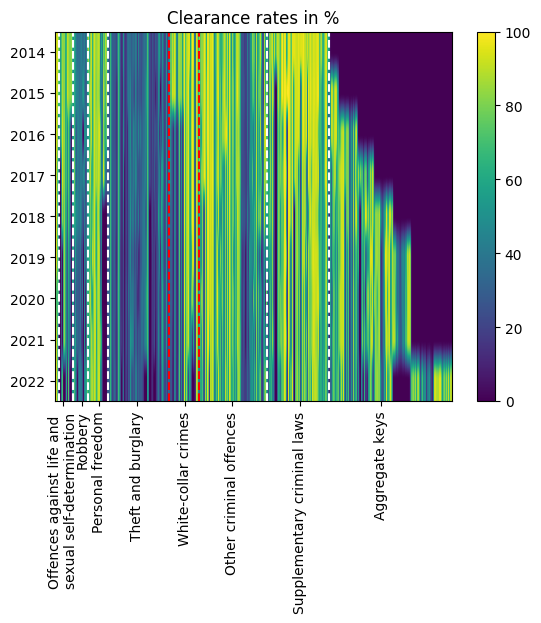

In [9]:
new_years = [*range(2014,2023)]
master_df.set_index('Offence', inplace=True)
numpy_df = master_df.to_numpy()
numpy_df = np.clip(numpy_df, None, 100)
plt.imshow(numpy_df.T, aspect='auto', cmap='viridis')
plt.colorbar()

plt.axvline(x=15, color='white', linestyle='--', linewidth=1.5)
plt.axvline(x=65, color='white', linestyle='--', linewidth=1.5)
plt.axvline(x=122, color='white', linestyle='--', linewidth=1.5)
plt.axvline(x=195, color='white', linestyle='--', linewidth=1.5)
plt.axvline(x=420, color='red', linestyle='--', linewidth=1.5)
plt.axvline(x=530, color='red', linestyle='--', linewidth=1.5)
plt.axvline(x=780, color='white', linestyle='--', linewidth=1.5)
plt.axvline(x=1010, color='white', linestyle='--', linewidth=1.5)
plt.xticks([30, 100, 160, 300, 480, 650, 900, 1200], ['Offences against life and \nsexual self-determination','Robbery', 'Personal freedom', 'Theft and burglary','White-collar crimes', 'Other criminal offences', 'Supplementary criminal laws', 'Aggregate keys'])
plt.xticks(rotation=90)
plt.yticks([0,1,2,3,4,5,6,7,8], new_years)
plt.title('Clearance rates in %')